Y-DATA 2020/21<br/>
Deep Learning HW3<br/>
Serge Tochilov

# Optimization Methods
Exercise credit: [DeepLearning.ai](https://www.coursera.org/learn/deep-neural-network)


In this notebook, you will learn advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this:
<!---
<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/cost.jpg' style='width:650px;height:300px;'>
-->
<img src='https://drive.google.com/uc?export=download&id=16u0MHFjGWQ2H_pVPEEcQoBuQT47jQraP' style='width:650px;height:300px;'>
<center>Minimizing the cost is like finding the lowest point in a hilly landscape.</center>

At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point.

**Notations**: As usual, $\dfrac{\partial J}{\partial a} = $ `da` for any variable `a`.

To get started, run the following code to import the libraries you will need.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import copy


# set default size of plots
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def sigmoid(x):
    '''
    Compute the sigmoid of x
    Arguments:
        x -- A scalar or numpy array of any size.
    Return:
        sigmoid(x) '''

    return 1/(1+np.exp(-x))


def relu(x):
    '''
    Compute the relu of x
    Arguments:
        x -- A scalar or numpy array of any size.
    Return:
        relu(x) '''

    return np.maximum(0, x)


def initialize_parameters(layer_dims):
    '''
    Arguments:
        layer_dims -- list containing the dimensions of each layer
            in our network
    
    Returns:
        parameters -- dictionary containing your parameters `W1`, `b1`, ..., `WL`, `bL`:
            W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
            b1 -- bias vector of shape (layer_dims[l], 1)
            Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
            bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
        - For example: the layer_dims for the "Planar Data classification model"
          would have been [2, 2, 1]. This means W1's shape was (2, 2), b1 was (1, 2),
          W2 was (2, 1) and b2 was (1, 1). Now you have to generalize it!
        - In the for loop, use parameters[f'W{l}'] to access Wl, where `l`
          is the iterative integer. '''
    
    np.random.seed(3)
    parameters = {}

    # number of layers in the network
    L = len(layer_dims)

    for l in range(1, L):

        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        
        assert parameters[f'W{l}'].shape == (layer_dims[l], layer_dims[l-1])
        assert parameters[f'b{l}'].shape == (layer_dims[l], 1)
        
    return parameters


def compute_cost(a3, Y):
    '''
    Implement the cost function
    
    Arguments:
        a3 -- post-activation, output of forward propagation
        Y -- "true" labels vector, same shape as `a3`
    
    Returns:
        cost - value of the cost function '''

    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1/m * np.sum(logprobs)
    
    return cost


def forward_propagation(X, parameters):
    '''
    Implements the forward propagation (and computes the loss) presented in Figure 2
    
    Arguments:
        X -- input dataset, of shape (input size, number of examples)
        parameters -- dictionary containing your parameters 'W1', 'b1', 'W2', 'b2', 'W3', 'b3'
    
    Returns:
        loss -- the loss function (vanilla logistic loss) '''
    
    # retrieve parameters
    W1, b1, W2, b2, W3, b3 = list(map(
        parameters.get, ('W1', 'b1', 'W2', 'b2', 'W3', 'b3')))
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache


def backward_propagation(X, Y, cache):
    '''
    Implement the backward propagation
    
    Arguments:
        X -- input dataset, of shape (input size, number of examples)
        Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
        cache -- cache output from forward_propagation()
    
    Returns:
        gradients -- dictionary of the gradients with respect to each parameter,
            activation and pre-activation variables '''

    m = X.shape[1]
    z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3 = cache
    
    dz3 = 1/m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims=True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, a2 > 0)
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims=True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, a1 > 0)
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims=True)
    
    gradients = {
        'dz3': dz3, 'dW3': dW3, 'db3': db3,
        'da2': da2, 'dz2': dz2, 'dW2': dW2, 'db2': db2,
        'da1': da1, 'dz1': dz1, 'dW1': dW1, 'db1': db1}
    
    return gradients


def predict(X, y, parameters):
    '''
    This function is used to predict the results of a n-layer neural network
    
    Arguments:
        X -- data set of examples you would like to label
        parameters -- parameters of the trained model
    
    Returns:
        p -- predictions for the given dataset X '''
    
    m = X.shape[1]
    p = np.zeros((1, m), dtype=np.int)
    
    # forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    p[0] = a3[0] > 0.5

    # print results
    print(f'Accuracy: {np.mean(p[0] == y[0]):.3f}')
    
    return p


def plot_decision_boundary(model, X, y):

    # find min and max values and add some padding
    x_min, x_max = X[0].min() - 1, X[0].max() + 1
    y_min, y_max = X[1].min() - 1, X[1].max() + 1
    h = 0.01

    # generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0], X[1], c=y, cmap=plt.cm.Spectral)


def predict_dec(parameters, X):
    '''
    Used for plotting decision boundary
    
    Arguments:
        parameters -- dictionary containing your parameters 
        X -- input data of size (m, K)
    
    Returns:
        predictions -- vector of predictions of our model (red: 0 / blue: 1) '''
    
    # predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    
    return a3 > 0.5


def load_dataset():

    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=0.2)

    # visualize the data
    plt.figure()
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral)
    plt.show()

    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

In [ ]:
def update_parameters_with_gd_test_case():

    np.random.seed(1)
    learning_rate = 0.01
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 3)
    b2 = np.random.randn(3, 1)

    dW1 = np.random.randn(2, 3)
    db1 = np.random.randn(2, 1)
    dW2 = np.random.randn(3, 3)
    db2 = np.random.randn(3, 1)
    
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    return parameters, grads, learning_rate


def random_mini_batches_test_case():

    np.random.seed(1)
    mini_batch_size = 64
    X = np.random.randn(12288, 148)
    Y = np.random.randn(1, 148) < 0.5

    return X, Y, mini_batch_size


def initialize_velocity_test_case():

    np.random.seed(1)
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 3)
    b2 = np.random.randn(3, 1)
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    return parameters


def update_parameters_with_momentum_test_case():

    np.random.seed(1)
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 3)
    b2 = np.random.randn(3, 1)

    dW1 = np.random.randn(2, 3)
    db1 = np.random.randn(2, 1)
    dW2 = np.random.randn(3, 3)
    db2 = np.random.randn(3, 1)

    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    v = {
        'dW1': np.array([
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]]),
        'dW2': np.array([
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]]),
        'db1': np.array([
            [ 0.],
            [ 0.]]),
        'db2': np.array([
            [ 0.],
            [ 0.],
            [ 0.]])}

    return parameters, grads, v
    

def initialize_adam_test_case():

    np.random.seed(1)
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 3)
    b2 = np.random.randn(3, 1)
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    return parameters


def update_parameters_with_adam_test_case():

    np.random.seed(1)
    v = {
        'dW1': np.array([
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]]),
        'dW2': np.array([
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]]),
        'db1': np.array([
            [ 0.],
            [ 0.]]),
        'db2': np.array([
            [ 0.],
            [ 0.],
            [ 0.]])}
    s = copy.deepcopy(v)

    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 3)
    b2 = np.random.randn(3, 1)

    dW1 = np.random.randn(2, 3)
    db1 = np.random.randn(2, 1)
    dW2 = np.random.randn(3, 3)
    db2 = np.random.randn(3, 1)
    
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    return parameters, grads, v, s

## 1. Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

**Warm-up exercise**: Implement the gradient descent update rule. The  gradient descent rule is, for $l\in\{1,...,L\}$: 

$$\begin{align}
W^{[l]} &= W^{[l]} - \alpha \text{ } dW^{[l]} \\
b^{[l]} &= b^{[l]} - \alpha \text{ } db^{[l]}
\end{align}$$

where $L$ is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary. Note that the iterator `l` starts at zero in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` while coding.

In [ ]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    '''
    Update parameters using one step of gradient descent
    
    Arguments:
        parameters -- dictionary containing your parameters to be updated:
            parameters[f'W{l}'] = Wl
            parameters[f'b{l}'] = bl
        grads -- dictionary containing your gradients to update each parameters:
            grads[f'dW{l}'] = dWl
            grads[f'db{l}'] = dbl
        learning_rate -- the learning rate, scalar
    
    Returns:
        parameters -- dictionary containing your updated parameters '''

    # number of layers in the neural networks
    L = len(parameters) // 2

    # update rule for each parameter
    for l in range(1, L+1):

        ### START CODE HERE ### (approx. 2 lines)
        Wl, bl, dWl, dbl = f'W{l}', f'b{l}', f'dW{l}', f'db{l}'
        parameters[Wl] = parameters[Wl] - learning_rate * grads[dWl]
        parameters[bl] = parameters[bl] - learning_rate * grads[dbl]
        ### END CODE HERE ###
        
    return parameters

In [ ]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print(f'W1 =\n{parameters["W1"]}')
print(f'b1 =\n{parameters["b1"]}')
print(f'W2 =\n{parameters["W2"]}')
print(f'b2 =\n{parameters["b2"]}')

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


**Expected Output**:

    W1 =
    [[ 1.63535156 -0.62320365 -0.53718766]
     [-1.07799357  0.85639907 -2.29470142]]
    b1 =
    [[ 1.74604067]
     [-0.75184921]]
    W2 =
    [[ 0.32171798 -0.25467393  1.46902454]
     [-2.05617317 -0.31554548 -0.3756023 ]
     [ 1.1404819  -1.09976462 -0.1612551 ]]
    b2 =
    [[-0.88020257]
     [ 0.02561572]
     [ 0.57539477]]

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example.
The update rule that you have just implemented does not change.
What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set.
The code examples below illustrates the difference between stochastic gradient descent and mini-batch gradient descent.

- **Batch Gradient Descent**:

``` python
X = data_input
y = labels
parameters = initialize_parameters(layers_dims)

for i in range(0, num_iterations):

    # forward propagation
    a, caches = forward_propagation(X, parameters)

    # compute cost
    cost = compute_cost(a, y)

    # backward propagation
    grads = backward_propagation(a, caches, parameters)

    # update parameters
    parameters = update_parameters(parameters, grads)   
```

- **Stochastic Gradient Descent**:

```python
X = data_input
y = labels
parameters = initialize_parameters(layers_dims)

for i in range(0, num_iterations):
    for j in range(0, m):

        # forward propagation
        a, caches = forward_propagation(X[:, j], parameters)

        # compute cost
        cost = compute_cost(a, y[:, j])

        # backward propagation
        grads = backward_propagation(a, caches, parameters)

        # update parameters
        parameters = update_parameters(parameters, grads)
```


In Stochastic Gradient Descent, you use only one training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this:
<!---
<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/kiank_sgd.png' style='width:750px;height:250px;'>
-->
<img src='https://drive.google.com/uc?export=download&id=1jkIoK_vl8yp19mSbh4BiodISVCLagnD9' style='width:750px;height:250px;'>
<center>SGD vs GD. "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD).</center>

**Note** also that implementing SGD requires three for-loops in total:
- Over the number of iterations
- Over the $m$ training examples
- Over the layers to update all the parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$

In practice, you'll often get the best results if you use neither the whole training set, nor only one training example to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.
<!---
<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/kiank_minibatch.png' style='width:750px;height:250px;'>
-->
<img src='https://drive.google.com/uc?export=download&id=1JBq4n4CwOYZHZvNiCnsgfUwWa_lA-Tqa' style='width:750px;height:250px;'>

<center>SGD vs Mini-batch GD. "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center>

**What you should remember**:
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you take to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-tuned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

## 2. Mini-batch Gradient Descent

Let's learn how to build mini-batches from the training set $(X, Y)$.

There are two steps:
- **Shuffle**: Create a shuffled version of the training set $(X, Y)$ as shown below. Each column of $X$ and $Y$ represents a training example. Note that the random shuffling is done synchronously between $X$ and $Y$. Such that after the shuffling the $i^{th}$ column of $X$ is the example corresponding to the $i^{th}$ label in $Y$. The shuffling step ensures that examples will be split randomly into different mini-batches.

<!---
<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/kiank_shuffle.png' style='width:550px;height:300px;'>
-->
<img src='https://drive.google.com/uc?export=download&id=1KJcCRXA-dpCGopxI2JSrhTu72-Iz3Ozi' style='width:550px;height:300px;'>

- **Partition**: Partition the shuffled $(X, Y)$ into mini-batches of size `mini_batch_size` (here $64$). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this:

<!---
<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/kiank_partition.png' style='width:550px;height:300px;'>
-->
<img src='https://drive.google.com/uc?export=download&id=1UQ8_-brOBnzeafg6gc2UQjJDcrXoIqdA' style='width:550px;height:300px;'>

**Exercise**: Implement `random_mini_batches`. We coded the shuffling part for you. To help you with the partitioning step, we give you the following code that selects the indexes for the first and second mini-batches:
```python
first_mini_batch_X = shuffled_X[:, 0:mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size:2 * mini_batch_size]
...
```

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\lfloor \frac{m}{mini\_batch\_size}\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ($m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor$). 

In [ ]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    '''
    Creates a list of random mini-batches from (X, Y)
    
    Arguments:
        X -- input data, of shape (input size, number of examples)
        Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
        mini_batch_size -- size of the mini-batches, integer
    
    Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y) '''
    
    # to make your "random" mini-batches the same as ours
    np.random.seed(seed)

    # number of training examples
    m = X.shape[1]
    mini_batches = []
        
    # Step 1: shuffle (X, Y)
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: partition (shuffled_X, shuffled_y)

    # maximum number of mini-batches of any size in your partitionning
    num_minibatches = m // mini_batch_size + 1

    for k in range(0, num_minibatches * mini_batch_size, mini_batch_size):

        ### START CODE HERE ### (approx. 2 lines)

        # handling the end case; need to check only lower slice index,
        # upper slice index is ok to be out of dim size as numpy clips automatically
        if k < m:
            mini_batch_X = shuffled_X[:, k:k + mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k:k + mini_batch_size]
        ### END CODE HERE ###

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print(f'shape of the 1st mini_batch_X: {mini_batches[0][0].shape}')
print(f'shape of the 2nd mini_batch_X: {mini_batches[1][0].shape}')
print(f'shape of the 3rd mini_batch_X: {mini_batches[2][0].shape}')
print(f'shape of the 1st mini_batch_Y: {mini_batches[0][1].shape}')
print(f'shape of the 2nd mini_batch_Y: {mini_batches[1][1].shape}')
print(f'shape of the 3rd mini_batch_Y: {mini_batches[2][1].shape}')
print(f'mini batch sanity check: {mini_batches[0][0][0][0:3]}')

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


**Expected Output**:

    shape of the 1st mini_batch_X: (12288, 64)
    shape of the 2nd mini_batch_X: (12288, 64)
    shape of the 3rd mini_batch_X: (12288, 20)
    shape of the 1st mini_batch_Y: (1, 64)
    shape of the 2nd mini_batch_Y: (1, 64)
    shape of the 3rd mini_batch_Y: (1, 20)
    mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]

**What you should remember**:
- Shuffling and Partitioning are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g. $16$, $32$, $64$, $128$.

## 3. Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. We will store the "direction" of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

<img src='https://github.com/omriallouche/ydata_deep_learning_2021/raw/main/assignments/optimization_methods/images/opt_momentum.png' style='width:400px;height:250px;'>
<center>The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence $v$ and then take a step in the direction of $v$.</center>

**Exercise**: Initialize the velocity `v`. It's a dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l\in\{1,...,L\}$:
```python
# numpy array of zeros with the same shape as parameters[f'W{l+1}']
v[f'dW{l+1}'] = ...

# numpy array of zeros with the same shape as parameters[f'b{l+1}']
v[f'db{l+1}'] = ...
```
**Note** that the iterator `l` starts at zero in the `for` loop while the first parameters are `v['dW1']` and `v['db1']` (that's a "one" on the superscript). This is why we are shifting `l` to `l+1` in the `for` loop.

In [ ]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    '''
    Initializes the velocity as a dictionary with:
        - keys: 'dW1', 'db1', ..., 'dWL', 'dbL' 
        - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
        parameters -- dictionary containing your parameters.
            parameters[f'W{l}'] = Wl
            parameters[f'b{l}'] = bl
    
    Returns:
        v -- dictionary containing the current velocity.
            v[f'dW{l}'] = velocity of dWl
            v[f'db{l}'] = velocity of dbl '''

    # number of layers in the neural networks
    L = len(parameters) // 2
    v = {}
    
    # initialize velocity
    for l in range(1, L+1):

        ### START CODE HERE ### (approx. 2 lines)
        Wl, bl = f'W{l}', f'b{l}'
        v['d' + Wl] = np.zeros_like(parameters[Wl])
        v['d' + bl] = np.zeros_like(parameters[bl])
        ### END CODE HERE ###
        
    return v

In [ ]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print(f'v[\'dW1\'] =\n{v["dW1"]}')
print(f'v[\'db1\'] =\n{v["db1"]}')
print(f'v[\'dW2\'] =\n{v["dW2"]}')
print(f'v[\'db2\'] =\n{v["db2"]}')

v['dW1'] =
[[0. 0. 0.]
 [0. 0. 0.]]
v['db1'] =
[[0.]
 [0.]]
v['dW2'] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v['db2'] =
[[0.]
 [0.]
 [0.]]


**Expected Output**:

    v['dW1'] =
    [[0. 0. 0.]
     [0. 0. 0.]]
    v['db1'] =
    [[0.]
     [0.]]
    v['dW2'] =
    [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
    v['db2'] =
    [[0.]
     [0.]
     [0.]]

**Exercise**:  Now, implement the parameters update with momentum. The momentum update rule is, for $l\in\{1,...,L\}$: 

$$\begin{align}
v_{dW^{[l]}} &= \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} &= W^{[l]} - \alpha v_{dW^{[l]}} \\
v_{db^{[l]}} &= \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} &= b^{[l]} - \alpha v_{db^{[l]}} 
\end{align}$$

where $L$ is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at zero in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` while coding.

In [ ]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    '''
    Update parameters using Momentum
    
    Arguments:
        parameters -- dictionary containing your parameters:
            parameters[f'W{l}'] = Wl
            parameters[f'b{l}'] = bl
        grads -- dictionary containing your gradients for each parameters:
                    grads[f'dW{l}'] = dWl
                    grads[f'db{l}'] = dbl
        v -- dictionary containing the current velocity:
                    v[f'dW{l}'] = ...
                    v[f'db{l}'] = ...
        beta -- the momentum hyperparameter, scalar
        learning_rate -- the learning rate, scalar
    
    Returns:
        parameters -- dictionary containing your updated parameters 
        v -- dictionary containing your updated velocities '''

    # number of layers in the neural networks
    L = len(parameters) // 2
    
    # perform Momentum update for each parameter
    for l in range(1, L+1):
        
        ### START CODE HERE ### (approx. 4 lines)
        Wl, bl = f'W{l}', f'b{l}'
        dWl, dbl = 'd' + Wl, 'd' + bl

        # compute velocities
        v[dWl] = beta * v[dWl] + (1 - beta) * grads[dWl]
        v[dbl] = beta * v[dbl] + (1 - beta) * grads[dbl]

        # update parameters
        parameters[Wl] = parameters[Wl] - learning_rate * v[dWl]
        parameters[bl] = parameters[bl] - learning_rate * v[dbl]
        ### END CODE HERE ###
        
    return parameters, v

In [ ]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta=0.9, learning_rate=0.01)
print(f'W1 =\n{parameters["W1"]}')
print(f'b1 =\n{parameters["b1"]}')
print(f'W2 =\n{parameters["W2"]}')
print(f'b2 =\n{parameters["b2"]}')
print(f'v[\'dW1\'] =\n{v["dW1"]}')
print(f'v[\'db1\'] =\n{v["db1"]}')
print(f'v[\'dW2\'] =\n{v["dW2"]}')
print(f'v[\'db2\'] =\n{v["db2"]}')

W1 =
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 =
[[ 1.74493465]
 [-0.76027113]]
W2 =
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 =
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v['dW1'] =
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v['db1'] =
[[-0.01228902]
 [-0.09357694]]
v['dW2'] =
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v['db2'] =
[[0.02344157]
 [0.16598022]
 [0.07420442]]


**Expected Output**:

    W1 =
    [[ 1.62544598 -0.61290114 -0.52907334]
     [-1.07347112  0.86450677 -2.30085497]]
    b1 =
    [[ 1.74493465]
     [-0.76027113]]
    W2 =
    [[ 0.31930698 -0.24990073  1.4627996 ]
     [-2.05974396 -0.32173003 -0.38320915]
     [ 1.13444069 -1.0998786  -0.1713109 ]]
    b2 =
    [[-0.87809283]
     [ 0.04055394]
     [ 0.58207317]]
    v['dW1'] =
    [[-0.11006192  0.11447237  0.09015907]
     [ 0.05024943  0.09008559 -0.06837279]]
    v['db1'] =
    [[-0.01228902]
     [-0.09357694]]
    v['dW2'] =
    [[-0.02678881  0.05303555 -0.06916608]
     [-0.03967535 -0.06871727 -0.08452056]
     [-0.06712461 -0.00126646 -0.11173103]]
    v['db2'] =
    [[0.02344157]
     [0.16598022]
     [0.07420442]]

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from $0.8$ to $0.999$. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in terms of reducing the value of the cost function $J$.

**What you should remember**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

## 4. Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
- It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $\hat v$ (with bias correction). 
- It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $\hat s$ (with bias correction). 
- It updates parameters in a direction based on combining information from $v$, $\hat v$, $s$ and $\hat s$.

The update rule is: 

$$\begin{align}
v_{dV^{[l]}} &= \beta_1 v_{dV^{[l]}} + (1 - \beta_1) \dfrac{\partial \mathcal{J} }{ \partial V^{[l]} } \\
\hat v_{dV^{[l]}} &= \dfrac{v_{dV^{[l]}}}{1 - \beta_1^{\ t}} \\
s_{dV^{[l]}} &= \beta_2 s_{dV^{[l]}} + (1 - \beta_2) \left(\dfrac{\partial \mathcal{J} }{\partial V^{[l]} }\right)^2 \\
\hat s_{dV^{[l]}} &= \dfrac{s_{dV^{[l]}}}{1 - \beta_2^{\ t}} \\
V^{[l]} &= V^{[l]} - \alpha \dfrac{\hat v_{dV^{[l]}}}{\sqrt{\hat s_{dV^{[l]}}} + \varepsilon}
\end{align}$$
where:
- $V\in\{W,b\}$
- $t$ counts the number of steps taken by Adam 
- $L$ is the number of layers, and $l\in\{1,...,L\}$
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

**Exercise**: Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables `v`, `s` are dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l\in\{1,...,L\}$:
```python
# numpy array of zeros with the same shape as parameters[f'W{l+1}']
v[f'dW{l+1}'] = ...

# numpy array of zeros with the same shape as parameters[f'b{l+1}']
v[f'db{l+1}'] = ...

# numpy array of zeros with the same shape as parameters[f'W{l+1}']
s[f'dW{l+1}'] = ...

# numpy array of zeros with the same shape as parameters[f'b{l+1}']
s[f'db{l+1}'] = ...
```

In [ ]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    '''
    Initializes v and s as two python dictionaries with:
        - keys: 'dW1', 'db1', ..., 'dWL', 'dbL' 
        - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
        parameters -- dictionary containing your parameters.
            parameters[f'W{l+1}'] = Wl
            parameters[f'b{l+1}'] = bl
    
    Returns: 
        v -- dictionary that will contain the exponentially weighted average of the gradient.
            v[f'dW{l+1}'] = ...
            v[f'db{l+1}'] = ...
        s -- dictionary that will contain the exponentially weighted average of the squared gradient.
            s[f'dW{l+1}'] = ...
            s[f'db{l+1}'] = ... '''
    
    # number of layers in the neural networks
    L = len(parameters) // 2
    v = {}
    s = {}
    
    # initialize v, s
    for l in range(1, L+1):

        ### START CODE HERE ### (approx. 4 lines)
        Wl, bl = f'W{l}', f'b{l}'
        dWl, dbl = 'd' + Wl, 'd' + bl

        v[dWl] = np.zeros_like(parameters[Wl])
        v[dbl] = np.zeros_like(parameters[bl])
    
        s[dWl] = np.zeros_like(parameters[Wl])
        s[dbl] = np.zeros_like(parameters[bl])
        ### END CODE HERE ###

    return v, s

In [ ]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print(f'v[\'dW1\'] =\n{v["dW1"]}')
print(f'v[\'db1\'] =\n{v["db1"]}')
print(f'v[\'dW2\'] =\n{v["dW2"]}')
print(f'v[\'db2\'] =\n{v["db2"]}')

print(f's[\'dW1\'] =\n{s["dW1"]}')
print(f's[\'db1\'] =\n{s["db1"]}')
print(f's[\'dW2\'] =\n{s["dW2"]}')
print(f's[\'db2\'] =\n{s["db2"]}')

v['dW1'] =
[[0. 0. 0.]
 [0. 0. 0.]]
v['db1'] =
[[0.]
 [0.]]
v['dW2'] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v['db2'] =
[[0.]
 [0.]
 [0.]]
s['dW1'] =
[[0. 0. 0.]
 [0. 0. 0.]]
s['db1'] =
[[0.]
 [0.]]
s['dW2'] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s['db2'] =
[[0.]
 [0.]
 [0.]]


**Expected Output**:

    v['dW1'] =
    [[0. 0. 0.]
     [0. 0. 0.]]
    v['db1'] =
    [[0.]
     [0.]]
    v['dW2'] =
    [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
    v['db2'] =
    [[0.]
     [0.]
     [0.]]
    s['dW1'] =
    [[0. 0. 0.]
     [0. 0. 0.]]
    s['db1'] =
    [[0.]
     [0.]]
    s['dW2'] =
    [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
    s['db2'] =
    [[0.]
     [0.]
     [0.]]

**Exercise**:  Now, implement the parameters update with Adam. Recall the general update rule is

$$\begin{align}
v_{dV^{[l]}} &= \beta_1 v_{dV^{[l]}} + (1 - \beta_1) \dfrac{\partial \mathcal{J} }{ \partial V^{[l]} } \\
\hat v_{dV^{[l]}} &= \dfrac{v_{dV^{[l]}}}{1 - \beta_1^{\ t}} \\
s_{dV^{[l]}} &= \beta_2 s_{dV^{[l]}} + (1 - \beta_2) \left(\dfrac{\partial \mathcal{J} }{\partial V^{[l]} }\right)^2 \\
\hat s_{dV^{[l]}} &= \dfrac{s_{dV^{[l]}}}{1 - \beta_2^{\ t}} \\
V^{[l]} &= V^{[l]} - \alpha \dfrac{\hat v_{dV^{[l]}}}{\sqrt{\hat s_{dV^{[l]}}} + \varepsilon}
\end{align}$$

**Note** that the iterator `l` starts at zero in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` while coding.

In [ ]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
    beta1=0.9, beta2=0.999, epsilon=1e-8):
    '''
    Update parameters using Adam
    
    Arguments:
        parameters -- dictionary containing your parameters:
            parameters[f'W{l+1}'] = Wl
            parameters[f'b{l+1}'] = bl
        grads -- dictionary containing your gradients for each parameters:
            grads[f'dW{l+1}'] = dWl
            grads[f'db{l+1}'] = dbl
        v -- Adam variable, moving average of the first gradient, dictionary
        s -- Adam variable, moving average of the squared gradient, dictionary
        learning_rate -- the learning rate, scalar
        beta1 -- exponential decay hyperparameter for the first moment estimates 
        beta2 -- exponential decay hyperparameter for the second moment estimates 
        epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
        parameters -- dictionary containing your updated parameters 
        v -- Adam variable, moving average of the first gradient, dictionary
        s -- Adam variable, moving average of the squared gradient, dictionary '''
    
    # number of layers in the neural networks
    L = len(parameters) // 2


    def adam_update(id):

        # perform Adam update on all parameters
        for l in range(1, L+1):

            Vl = f'{id}{l}'
            dVl = 'd' + Vl

            # moving average of the gradients
            # inputs: `v`, `grads`, `beta1`
            # output: `v`
            ### START CODE HERE ### (approx. 2 lines)
            v[dVl] = beta1 * v[dVl] + (1 - beta1) * grads[dVl]
            ### END CODE HERE ###

            # compute bias-corrected first moment estimate
            # inputs: `v`, `beta1`, `t`
            # output: `v_corrected`
            ### START CODE HERE ### (approx. 2 lines)
            v_corrected = v[dVl] / (1 - np.power(beta1, t))
            ### END CODE HERE ###

            # moving average of the squared gradients
            # inputs: `s`, `grads`, `beta2`
            # output: `s`
            ### START CODE HERE ### (approx. 2 lines)
            s[dVl] = beta2 * s[dVl] + (1 - beta2) * np.square(grads[dVl])
            ### END CODE HERE ###

            # compute bias-corrected second raw moment estimate
            # inputs: `s`, `beta2`, `t`
            # output: `s_corrected`
            ### START CODE HERE ### (approx. 2 lines)
            s_corrected = s[dVl] / (1 - np.power(beta2, t))
            ### END CODE HERE ###

            # update parameters
            # inputs: `parameters`, `learning_rate`, `v_corrected`, `s_corrected`, `epsilon`
            # output: `parameters`
            ### START CODE HERE ### (approx. 2 lines)
            parameters[Vl] = parameters[Vl] - learning_rate * v_corrected / (
                np.sqrt(s_corrected) + epsilon)
            ### END CODE HERE ###


    adam_update('W')
    adam_update('b')

    return parameters, v, s

In [ ]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t=2)

print(f'W1 =\n{parameters["W1"]}')
print(f'b1 =\n{parameters["b1"]}')
print(f'W2 =\n{parameters["W2"]}')
print(f'b2 =\n{parameters["b2"]}')

print(f'v[\'dW1\'] =\n{v["dW1"]}')
print(f'v[\'db1\'] =\n{v["db1"]}')
print(f'v[\'dW2\'] =\n{v["dW2"]}')
print(f'v[\'db2\'] =\n{v["db2"]}')

print(f's[\'dW1\'] =\n{s["dW1"]}')
print(f's[\'db1\'] =\n{s["db1"]}')
print(f's[\'dW2\'] =\n{s["dW2"]}')
print(f's[\'db2\'] =\n{s["db2"]}')

W1 =
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 =
[[ 1.75225313]
 [-0.75376553]]
W2 =
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 =
[[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v['dW1'] =
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v['db1'] =
[[-0.01228902]
 [-0.09357694]]
v['dW2'] =
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v['db2'] =
[[0.02344157]
 [0.16598022]
 [0.07420442]]
s['dW1'] =
[[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s['db1'] =
[[1.51020075e-05]
 [8.75664434e-04]]
s['dW2'] =
[[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s['db2'] =
[[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


**Expected Output**:

    W1 =
    [[ 1.63178673 -0.61919778 -0.53561312]
     [-1.08040999  0.85796626 -2.29409733]]
    b1 =
    [[ 1.75225313]
     [-0.75376553]]
    W2 =
    [[ 0.32648046 -0.25681174  1.46954931]
     [-2.05269934 -0.31497584 -0.37661299]
     [ 1.14121081 -1.09244991 -0.16498684]]
    b2 =
    [[-0.88529979]
     [ 0.03477238]
     [ 0.57537385]]
    v['dW1'] =
    [[-0.11006192  0.11447237  0.09015907]
     [ 0.05024943  0.09008559 -0.06837279]]
    v['db1'] =
    [[-0.01228902]
     [-0.09357694]]
    v['dW2'] =
    [[-0.02678881  0.05303555 -0.06916608]
     [-0.03967535 -0.06871727 -0.08452056]
     [-0.06712461 -0.00126646 -0.11173103]]
    v['db2'] =
    [[0.02344157]
     [0.16598022]
     [0.07420442]]
    s['dW1'] =
    [[0.00121136 0.00131039 0.00081287]
     [0.0002525  0.00081154 0.00046748]]
    s['db1'] =
    [[1.51020075e-05]
     [8.75664434e-04]]
    s['dW2'] =
    [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
     [1.57413361e-04 4.72206320e-04 7.14372576e-04]
     [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
    s['db2'] =
    [[5.49507194e-05]
     [2.75494327e-03]
     [5.50629536e-04]]

You now have three working optimization algorithms (Mini-batch Gradient Descent, Momentum, Adam). Let's implement a model with each of these optimizers and observe the difference.

## 5. Model with different optimization algorithms

Let's use the following `moons` dataset to test the different optimization methods. The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.

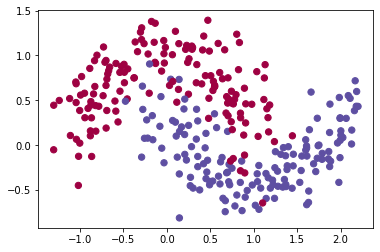

In [ ]:
train_X, train_Y = load_dataset()

We have already implemented a 3-layer neural network. You will train it with: 
- Mini-batch **Gradient Descent**: it will call your function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call your functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`
- Mini-batch **Adam**: it will call your functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

In [ ]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
    beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    '''
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
        X -- input data, of shape (2, number of examples)
        Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
        layers_dims -- list, containing the size of each layer
        learning_rate -- the learning rate, scalar
        mini_batch_size -- the size of a mini batch
        beta -- Momentum hyperparameter
        beta1 -- exponential decay hyperparameter for the past gradients estimates 
        beta2 -- exponential decay hyperparameter for the past squared gradients estimates 
        epsilon -- hyperparameter preventing division by zero in Adam updates
        num_epochs -- number of epochs
        print_cost -- True to print the cost every 1000 epochs

    Returns:
        parameters -- dictionary containing your updated parameters '''

    # number of layers in the neural networks
    L = len(layers_dims)

    # to keep track of the cost
    costs = []

    # initializing the counter required for Adam update
    t = 0

    # for grading purposes, so that your "random" mini-batches are the same as ours
    seed = 10
    
    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # initialize the optimizer
    if optimizer == 'gd':
        # no initialization required for gradient descent
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    else:
        raise ValueError(f'Optimization mode \'{optimizer}\' is not supported')
    
    # optimization loop
    for i in range(num_epochs):
        
        # define the random mini-batches; we increment the seed to reshuffle
        # the dataset differently after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # select a mini-batch
            minibatch_X, minibatch_Y = minibatch

            # forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # compute cost
            cost = compute_cost(a3, minibatch_Y)

            # backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # update parameters
            if optimizer == 'gd':

                parameters = update_parameters_with_gd(parameters, grads, learning_rate)

            elif optimizer == 'momentum':

                parameters, v = update_parameters_with_momentum(parameters, grads,
                    v, beta, learning_rate)

            elif optimizer == 'adam':

                # Adam counter
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters, grads,
                    v, s, t, learning_rate, beta1, beta2,  epsilon)
        
        # print the cost every 1000 epoch
        if print_cost and i % 1000 == 999:
            print(f'Cost after epoch {i+1}: {cost:.3f}')
        if print_cost and i % 100 == 99:
            costs.append(cost)

    # plot the cost
    print()
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Epochs (per 100)')
    plt.title(f'Learning rate = {learning_rate}')
    plt.show()

    return parameters

You will now run this 3-layer neural network with each of the three optimization methods.

### 5.1. Mini-batch Gradient Descent

Run the following code to see how the model performs with mini-batch gradient descent.

In [ ]:
def run_model(optimizer, title):

    # train 3-layer model
    layers_dims = [train_X.shape[0], 5, 2, 1]
    parameters = model(train_X, train_Y, layers_dims, optimizer=optimizer)
    print()

    # predict
    predictions = predict(train_X, train_Y, parameters)
    print()

    # plot decision boundary
    plt.figure()
    plt.title(title)
    plt.xlim([-1.5, 2.5])
    plt.ylim([-1, 1.5])
    plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)
    plt.show()

Cost after epoch 1000: 0.693
Cost after epoch 2000: 0.650
Cost after epoch 3000: 0.577
Cost after epoch 4000: 0.585
Cost after epoch 5000: 0.550
Cost after epoch 6000: 0.534
Cost after epoch 7000: 0.424
Cost after epoch 8000: 0.504
Cost after epoch 9000: 0.504
Cost after epoch 10000: 0.435



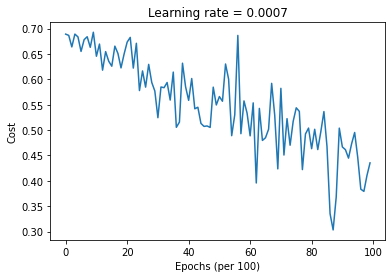


Accuracy: 0.797



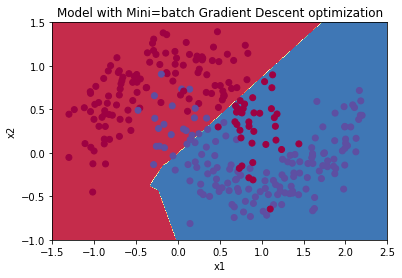

In [ ]:
run_model('gd', 'Model with Mini=batch Gradient Descent optimization')

### 5.2. Mini-batch Gradient Descent with Momentum

Run the following code to see how the model performs with momentum. Because this example is relatively simple the gains from using momentum are small, but for more complex problems you might see bigger gains.

Cost after epoch 1000: 0.693
Cost after epoch 2000: 0.650
Cost after epoch 3000: 0.577
Cost after epoch 4000: 0.586
Cost after epoch 5000: 0.550
Cost after epoch 6000: 0.534
Cost after epoch 7000: 0.424
Cost after epoch 8000: 0.504
Cost after epoch 9000: 0.504
Cost after epoch 10000: 0.435



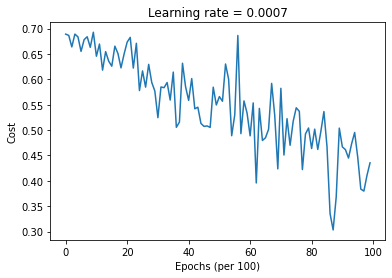


Accuracy: 0.797



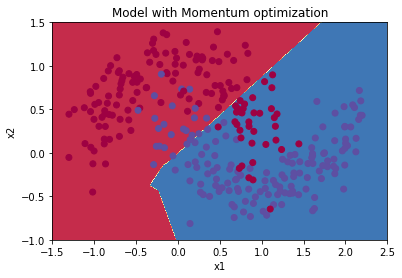

In [ ]:
run_model('momentum', 'Model with Momentum optimization')

### 5.3. Mini-batch with Adam

Run the following code to see how the model performs with Adam.

Cost after epoch 1000: 0.120
Cost after epoch 2000: 0.269
Cost after epoch 3000: 0.070
Cost after epoch 4000: 0.102
Cost after epoch 5000: 0.040
Cost after epoch 6000: 0.064
Cost after epoch 7000: 0.103
Cost after epoch 8000: 0.092
Cost after epoch 9000: 0.176
Cost after epoch 10000: 0.169



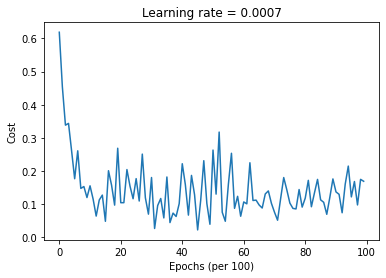


Accuracy: 0.940



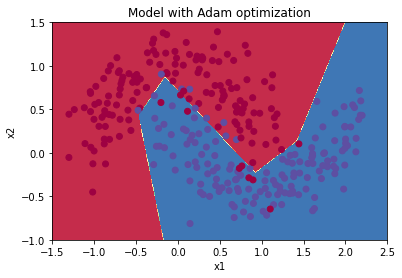

In [ ]:
run_model('adam', 'Model with Adam optimization')

### 5.4. Summary

|**Optimization method**|**Accuracy**|**Cost shape**|
|---|---|---|
|Gradient descent|79.7%|oscillations, slow convergence|
|Momentum|79.7%|oscillations, slow convergence|
|Adam|94.0%|oscillations, fast convergence|

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligible. Also, the huge oscillations you see in the cost come from the fact that some mini-batches are more difficult than others for the optimization algorithm.

On the other hand, Adam clearly outperforms Mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf